This code is for examining those proteins where I have both the autoinhibited and active state.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json

In [13]:
'''
Isolate the proteins with both states
'''

df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')
proteins = pd.read_csv('./project_pipeline/data/proteins.tsv', sep='\t').astype('object')

df['distinct_count'] = df.groupby('uniprot')['state'].transform('nunique')

# Dataframe with only proteins with both states
both_states = df[df['distinct_count'] == 2]
states_proteins = both_states['uniprot'].drop_duplicates()
states_list = both_states['uniprot'].unique()

# Get gene names
gene_names = proteins[proteins['uniprot'].isin(states_list)]
gene_names_list = gene_names['gene_name'].unique()
print(gene_names_list)
print(len(both_states))
print(states_list)
both_states.head()

['MAPK1' 'RAN' 'SRC' 'CBL' 'FLNA' 'DNMT3A' 'DNMT1' 'OTULIN' 'PTPN6' 'CBS'
 'ETS1' 'CYTH3' 'TRERF1' 'HCN1' 'OTUD7B' nan 'PPP5C']
281
['O08967' 'O60741' 'P07038' 'P12931' 'P21333' 'P22681' 'P26358' 'P27577'
 'P28482' 'P29350' 'P35520' 'P53042' 'P60240' 'P62826' 'Q6GQQ9' 'Q8NQJ3'
 'Q96BN8' 'Q9Y6K1']


,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,conformation,state,organism,date,notes,distinct_count
13,O08967,2r09,"251-265,383-395",77-206,3.179,92.857143,96.923077,0.968,1.593,Closed,Autoinhibited,Mus musculus,['2007-08-17'],NaN,2
14,O08967,2r0d,"251-265,383-395",77-206,3.115,100.0,100.0,0.894,1.619,Closed,Autoinhibited,Mus musculus,['2007-08-18'],NaN,2
15,O08967,6bbp,"251-265,383-395",77-206,24.061,100.0,100.0,0.925,51.878,Open,Active,Mus musculus,['2017-10-19'],NaN,2
16,O08967,6bbq,"251-265,383-395",77-206,24.786,100.0,100.0,0.926,54.034,Open,Active,Mus musculus,['2017-10-19'],NaN,2
17,O60741,5u6p,401-479,480-604,1.182,100.0,100.0,0.917,1.29,Closed,Active,Homo sapiens,['2016-12-08'],NaN,2


Number  of Active and open: 89
Number of active and closed: 9
Number of autoinhibited and open: 2
Number of autoinhibited and closed: 141


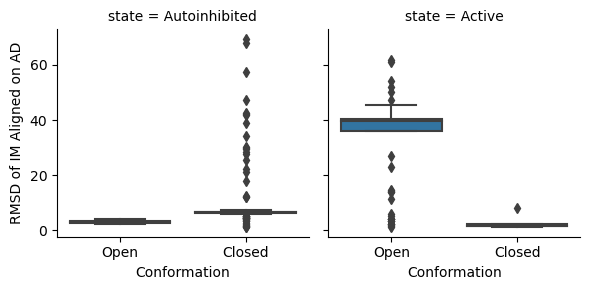

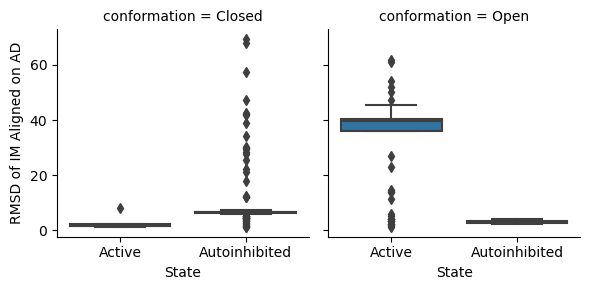

In [7]:
df_disorder = both_states.astype({'2_comp': 'float'})
df_active = df_disorder[df_disorder['state'] == 'Active']
df_autoin = df_disorder[df_disorder['state'] == 'Autoinhibited']
df_open = df_disorder[df_disorder['conformation'] == 'Open']
df_closed = df_disorder[df_disorder['conformation'] == 'Closed']

g1 = sns.FacetGrid(data=df_disorder, col='state')
g1.map(sns.boxplot, 'conformation', '2_comp', order=['Open', 'Closed'])
g1.set_axis_labels('Conformation', 'RMSD of IM Aligned on AD')
g1.savefig('./project_pipeline/data/figures/subset_rmsd_state.png', dpi=300, bbox_inches='tight')

g2 = sns.FacetGrid(data=df_disorder, col='conformation')
g2.map(sns.boxplot, 'state', '2_comp', order=['Active', 'Autoinhibited'])
g2.set_axis_labels('State', 'RMSD of IM Aligned on AD')
g2.savefig('./project_pipeline/data/figures/subset_rmsd_conformation.png', dpi=300, bbox_inches='tight')


act_op = df_disorder[(df_disorder['state'] == 'Active') & (df_disorder['conformation'] == 'Open')]
act_clo = df_disorder[(df_disorder['state'] == 'Active') & (df_disorder['conformation'] == 'Closed')]
aut_op = df_disorder[(df_disorder['state'] == 'Autoinhibited') & (df_disorder['conformation'] == 'Open')]
aut_clo = df_disorder[(df_disorder['state'] == 'Autoinhibited') & (df_disorder['conformation'] == 'Closed')]

print('Number  of Active and open: ' + str(len(act_op)))
print('Number of active and closed: ' + str(len(act_clo)))
print('Number of autoinhibited and open: ' + str(len(aut_op)))
print('Number of autoinhibited and closed: ' + str(len(aut_clo)))

In [67]:
'''
Determine the distributions of open/closed and active/autoinhibited proteins in the PDB
'''

df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

# Number of pdb files
print('Number of pdb files: ' + str(len(df)))

# Number of PDB files with state or conformation information
df = df.dropna(subset=['state', 'conformation'])
print('Dropping rows gives us: ' + str(len(df)) + ' files and ' + str(len(df.groupby(['uniprot']).size())) + ' proteins')

# Organize by state and conformation
pdb_groups = df.groupby(['state', 'conformation']).size()

pdb_df = pdb_groups.to_frame(name='PDB').reset_index()
pdb_df.head()

Number of pdb files: 824
Dropping rows gives us: 551 files and 92 proteins


,state,conformation,PDB
0,Active,Closed,39
1,Active,Open,141
2,Autoinhibited,Closed,365
3,Autoinhibited,Open,6


In [87]:
'''
Determine the state and conformation of each AlphaFold2 structure
'''

df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

# Number of pdb files
print('Number of pdb files: ' + str(len(df)) + ' and number of proteins: ' + str(len(df.groupby(['uniprot']).size())))

df = df.dropna(subset=['conformation', 'state'])

# Count the number of unique uniprot ids within the original dataframe
num_proteins = df.groupby(['uniprot']).size()

# Find the pdb id with the lowest 2_comp value for each uniprot id. We use this as a proxy for the AlphaFold2 structure's conformation and state
df = df.sort_values(by=['uniprot', '2_comp'])
df = df.drop_duplicates(subset=['uniprot'], keep='first')

df = df.dropna(subset=['conformation', 'state'])

# What do the groups look like for 2_comp values greater than 15?
df_greater = df[df['2_comp'] > 15]
num_combos_greater = df_greater.groupby(['conformation', 'state']).size()

# Ignore any structures that have a 2_comp value greater than 15
df_lesser = df[df['2_comp'] <= 15]
# Find the number of structures for each conformation and state
num_combos = df_lesser.groupby(['conformation', 'state']).size()


print(len(num_proteins))
print('Greater than 15: ', num_combos_greater)
print('Less than 15', num_combos)

greater_15 = num_combos_greater.to_frame(name='AF_PDB_nomatch').reset_index()
aligned_92 = num_combos.to_frame(name='DeepMind').reset_index()
# Save the dataframe
# df.to_csv('./project_pipeline/data/deepmind_conf_state.tsv', sep='\t', index=False)

# num_proteins.to_csv('./project_pipeline/data/num_proteins.tsv', sep='\t')
aligned_92.head()

Number of pdb files: 824 and number of proteins: 123
92
Greater than 15:  conformation  state        
Closed        Autoinhibited    10
Open          Active            7
              Autoinhibited     2
dtype: int64
Less than 15 conformation  state        
Closed        Active           10
              Autoinhibited    50
Open          Active           12
              Autoinhibited     1
dtype: int64


,conformation,state,DeepMind
0,Closed,Active,10
1,Closed,Autoinhibited,50
2,Open,Active,12
3,Open,Autoinhibited,1


In [60]:
'''
Repeat the above steps, but for structures deposited after April 30th, 2018
'''

df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

# Remove any rows without state or conformation information
df = df.dropna(subset=['conformation', 'state'])

df['date'] = df['date'].str.strip('['']')

# Convert the date column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Determine which proteins have structures deposited after April 30th, 2018
df_post_2018 = df[df['date'] > '2018-04-30']
df_pre_2018 = df[df['date'] <= '2018-04-30']

# Get the UniProt ids for the proteins deposited before and after April 30th, 2018
post_2018_proteins = df_post_2018['uniprot'].unique()
pre_2018_proteins = df_pre_2018['uniprot'].unique()

# Find any proteins that have structures deposited both before and after April 30th, 2018
both = np.intersect1d(post_2018_proteins, pre_2018_proteins)

# Remove those proteins from the list of proteins deposited after April 30th, 2018
post_2018_proteins = np.setdiff1d(post_2018_proteins, both)

# Remove any structures deposited before April 30th, 2018
df_post_2018 = df_post_2018[df_post_2018['uniprot'].isin(post_2018_proteins)]


# Find the pdb id with the lowest 2_comp value for each uniprot id. We use this as a proxy for the AlphaFold2 structure's conformation and state
df_post_2018 = df_post_2018.sort_values(by=['uniprot', '2_comp'])
df_post_2018 = df_post_2018.drop_duplicates(subset=['uniprot'], keep='first')

# Count the number of unique uniprot ids within the original dataframe
num_proteins_post = df_post_2018.groupby(['uniprot']).size()

df_greater = df_post_2018[df_post_2018['2_comp'] > 15]
# Ignore any structures that have a 2_comp value greater than 15
df_lesser = df_post_2018[df_post_2018['2_comp'] <= 15]

# Find the number of structures for each conformation and state
greater_15_post = df_greater.groupby(['conformation', 'state']).size()
less_15_post = df_lesser.groupby(['conformation', 'state']).size()

print('For proteins only after 2018: ', str(len(num_proteins_post)) + '\n', greater_15_post, less_15_post)

# Do the above, but for proteins that have structures deposited before April 30th, 2018
df_pre_2018 = df[df['uniprot'].isin(pre_2018_proteins)]
df_pre_2018 = df_pre_2018.sort_values(by=['uniprot', '2_comp'])
df_pre_2018 = df_pre_2018.drop_duplicates(subset=['uniprot'], keep='first')

# Count the number of unique uniprot ids within the original dataframe
num_proteins_pre = df_pre_2018.groupby(['uniprot']).size()

df_greater = df_pre_2018[df_pre_2018['2_comp'] > 15]
# Ignore any structures that have a 2_comp value greater than 15
df_lesser = df_pre_2018[df_pre_2018['2_comp'] <= 15]

# Find the number of structures for each conformation and state
greater_15_pre = df_greater.groupby(['conformation', 'state']).size()
less_15_pre = df_lesser.groupby(['conformation', 'state']).size()

print('For proteins before 2018: ', str(len(num_proteins_pre)) + '\n', greater_15_pre, less_15_pre)
# Save the dataframe
# df.to_csv('./project_pipeline/data/deepmind_conf_state_post_2018.tsv', sep='\t', index=False)

# num_proteins.to_csv('./project_pipeline/data/num_proteins_post_2018.tsv', sep='\t')

For proteins only after 2018:  11
 conformation  state        
Closed        Autoinhibited    2
Open          Active           2
              Autoinhibited    1
dtype: int64 conformation  state        
Closed        Autoinhibited    5
Open          Active           1
dtype: int64
For proteins before 2018:  81
 conformation  state        
Closed        Autoinhibited    8
Open          Active           5
              Autoinhibited    1
dtype: int64 conformation  state        
Closed        Active           10
              Autoinhibited    45
Open          Active           11
              Autoinhibited     1
dtype: int64


In [64]:
'''
There are two proteins with structures both before and after 2018
whose AlphaFold predictions are most accurate with structures published _after_ April 30th, 2018. Who are they?
'''
df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

# Remove any rows without state or conformation information
df = df.dropna(subset=['conformation', 'state'])

df['date'] = df['date'].str.strip('['']')

# Convert the date column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Determine which proteins have structures deposited before April 30th, 2018
df_only_pre_2018= df[df['date'] <= '2018-04-30']

# Get the UniProt ids for the proteins deposited before and after April 30th, 2018
pre_2018_proteins = df_only_pre_2018['uniprot'].unique()

# Create a dataframe with proteins who have structures deposited before and after April 30th, 2018
df_before_after = df[df['uniprot'].isin(pre_2018_proteins)]

'''Do everything for only structures before 2018'''
df_only_pre_2018 = df_only_pre_2018.sort_values(by=['uniprot', '2_comp'])
df_only_pre_2018 = df_only_pre_2018.drop_duplicates(subset=['uniprot'], keep='first')

# Count the number of unique uniprot ids within this dataframe
num_proteins_pre = df_only_pre_2018.groupby(['uniprot']).size()

df_greater_pre = df_only_pre_2018[df_only_pre_2018['2_comp'] > 15]
# Ignore any structures that have a 2_comp value greater than 15
df_lesser_pre = df_only_pre_2018[df_only_pre_2018['2_comp'] <= 15]

# Find the number of structures for each conformation and state
greater_15_pre = df_greater_pre.groupby(['conformation', 'state']).size()
less_15_pre = df_lesser_pre.groupby(['conformation', 'state']).size()

print('For proteins before 2018: ', str(len(num_proteins_pre)) + '\n', greater_15_pre, less_15_pre)

'''Do everything for structures before and after 2018'''
# Find the pdb id with the lowest 2_comp value for each uniprot id. We use this as a proxy for the AlphaFold2 structure's conformation and state
df_before_after = df_before_after.sort_values(by=['uniprot', '2_comp'])
df_before_after = df_before_after.drop_duplicates(subset=['uniprot'], keep='first')

# Count the number of unique uniprot ids within this dataframe
num_proteins_before_after = df_before_after.groupby(['uniprot']).size()

df_greater_both = df_before_after[df_before_after['2_comp'] > 15]
# Ignore any structures that have a 2_comp value greater than 15
df_lesser_both = df_before_after[df_before_after['2_comp'] <= 15]

# Find the number of structures for each conformation and state
greater_15_both = df_greater_both.groupby(['conformation', 'state']).size()
less_15_both = df_lesser_both.groupby(['conformation', 'state']).size()

print('For proteins before and after 2018: ', str(len(num_proteins_before_after)) + '\n', greater_15_both, less_15_both)

'''Find the two proteins in df_greater_pre that are not in df_greater_both'''
df_greater_pre = df_greater_pre.reset_index()
df_greater_both = df_greater_both.reset_index()

# Find the proteins in df_greater_pre that are not in df_greater_both
df_greater_pre = df_greater_pre[~df_greater_pre['uniprot'].isin(df_greater_both['uniprot'])]
df_greater_pre.head()

For proteins before 2018:  81
 conformation  state        
Closed        Autoinhibited    9
Open          Active           6
              Autoinhibited    1
dtype: int64 conformation  state        
Closed        Active           10
              Autoinhibited    44
Open          Active           10
              Autoinhibited     1
dtype: int64
For proteins before and after 2018:  81
 conformation  state        
Closed        Autoinhibited    8
Open          Active           5
              Autoinhibited    1
dtype: int64 conformation  state        
Closed        Active           10
              Autoinhibited    45
Open          Active           11
              Autoinhibited     1
dtype: int64


,index,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,conformation,state,organism,date,notes
1,40,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Open,Active,"""Neurospora crassa""",2002-08-21,NaN
11,344,P60240,4s20,1-110,"147-416,441-659",11.12,99.090909,99.795501,3.08,29.595,Closed,Autoinhibited,Escherichia coli,2015-01-16,NaN


In [89]:
'''
Repeat the above steps, but for proteins that have both structures.
'''
df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

df  = df.dropna(subset=['conformation', 'state'])

df['distinct_count'] = df.groupby('uniprot')['state'].transform('nunique')

# Dataframe with only proteins with both states
both_states = df[df['distinct_count'] == 2]

# Count the number of unique uniprot ids within the original dataframe
num_proteins = both_states.groupby(['uniprot']).size()
print('The number of proteins is: ' + str(len(num_proteins)))

# Find the pdb id with the lowest 2_comp value for each uniprot id. We use this as a proxy for the AlphaFold2 structure's conformation and state
both_states = both_states.sort_values(by=['uniprot', '2_comp'])
both_states = both_states.drop_duplicates(subset=['uniprot'], keep='first')

both_states_greater = both_states[both_states['2_comp'] > 15]
# Ignore any structures that have a 2_comp value greater than 15
both_states_lesser = both_states[both_states['2_comp'] <= 15]

# Find the number of structures for each conformation and state
greater = both_states_greater.groupby(['conformation', 'state']).size()
less = both_states_lesser.groupby(['conformation', 'state']).size()

print(len(num_proteins), greater, less)

aligned_18 = less.to_frame(name='Two-State DM').reset_index()
aligned_18.head()

The number of proteins is: 18
18 conformation  state        
Closed        Autoinhibited    2
Open          Active           1
dtype: int64 conformation  state        
Closed        Active           3
              Autoinhibited    6
Open          Active           6
dtype: int64


,conformation,state,Two-State DM
0,Closed,Active,3
1,Closed,Autoinhibited,6
2,Open,Active,6


In [51]:
'''
What about proteins with both structures after April 30th, 2018?
'''

df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

df = df.dropna(subset=['conformation', 'state'])

df['distinct_count'] = df.groupby('uniprot')['state'].transform('nunique')

# Dataframe with only proteins with both states
both_states = df[df['distinct_count'] == 2]

# Clean up the dates for the next step
both_states['date'] = both_states['date'].str.strip('['']')

# Convert the date column to datetime objects
both_states['date'] = pd.to_datetime(both_states['date'])

# Filter out any structures deposited before March 30th, 2018
both_states = both_states[both_states['date'] > '2018-04-30']

# Find the pdb id with the lowest 2_comp value for each uniprot id. We use this as a proxy for the AlphaFold2 structure's conformation and state
both_states = both_states.sort_values(by=['uniprot', '2_comp'])
both_states = both_states.drop_duplicates(subset=['uniprot'], keep='first')

both_states = both_states.dropna(subset=['state', 'conformation'])

# Count the number of unique uniprot ids within the cleaned dataframe
num_proteins = both_states.groupby(['uniprot']).size()

both_states_greater = both_states[both_states['2_comp'] > 15]
# Ignore any structures that have a 2_comp value greater than 15
both_states_lesser = both_states[both_states['2_comp'] <= 15]

# Find the number of structures for each conformation and state
greater = both_states_greater.groupby(['conformation', 'state']).size()
less = both_states_lesser.groupby(['conformation', 'state']).size()

print(len(num_proteins), greater, less)

10 conformation  state        
Closed        Autoinhibited    1
Open          Active           2
dtype: int64 conformation  state        
Closed        Active           2
              Autoinhibited    3
Open          Active           2
dtype: int64


/tmp/ipykernel_1022708/3390753231.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_states['date'] = both_states['date'].str.strip('['']')
/tmp/ipykernel_1022708/3390753231.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_states['date'] = pd.to_datetime(both_states['date'])


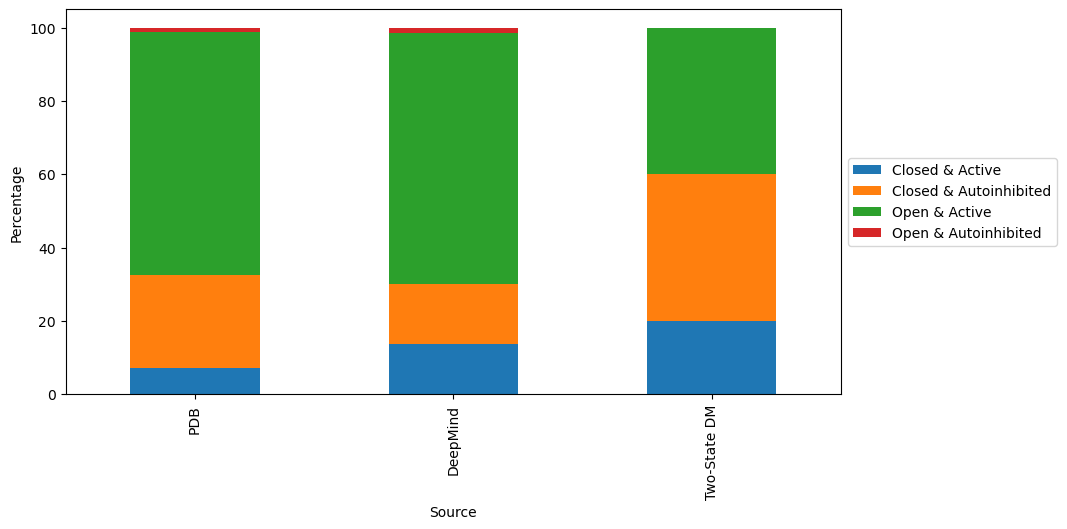

conformation,Closed,Open,Closed,Open
state,Active,Active,Autoinhibited,Autoinhibited
PDB,7.08,25.59,66.24,1.09
DeepMind,13.70,16.44,68.49,1.37
Two-State DM,20.00,40.00,40.00,0.00


In [94]:
'''
Here we combine pdb_df, aligned_92, and aligned_18 into one dataframe, flip the rows and columns, and make a bar chart showing
percentages of each conformation/state combination
'''

# Combine the dataframes
combined = pdb_df.merge(aligned_92, on=['conformation', 'state'], how='outer')
combined = combined.merge(aligned_18, on=['conformation', 'state'], how='outer')

# Fill in any NaN values with 0
combined = combined.fillna(0)

# Convert the counts to percentages
combined['PDB'] = combined['PDB'].astype('float')
combined['DeepMind'] = combined['DeepMind'].astype('float')
combined['Two-State DM'] = combined['Two-State DM'].astype('float')

combined['PDB'] = round(combined['PDB'] / combined['PDB'].sum() * 100, 2)
combined['DeepMind'] = round(combined['DeepMind'] / combined['DeepMind'].sum() * 100, 2)
combined['Two-State DM'] = round(combined['Two-State DM'] / combined['Two-State DM'].sum() * 100, 2)

# Flip the rows and columns
combined = combined.set_index(['conformation', 'state']).T

# Plot the bar chart using matplotlib
fig, ax = plt.subplots(figsize=(10, 5))
combined.plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel('Percentage')
ax.set_xlabel('Source')
# Fix the placement of the legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Closed & Active', 'Closed & Autoinhibited', 
                                                              'Open & Active', 'Open & Autoinhibited', 
                                                              'Closed & Active', 'Closed & Autoinhibited', 
                                                              'Open & Active', 'Open & Autoinhibited', 
                                                              'Closed & Active', 'Closed & Autoinhibited', 
                                                              'Open &  Active', 'Open & Autoinhibited'])

plt.savefig('./project_pipeline/data/figures/combined_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()
combined.head()

